In [1426]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_digits


In [1427]:
# This class plots the relevant raster plot of spikes and validation accuracy over time

class Spike_Plotter:
    def __init__(self):
        pass
     
    # Raster plot of spiking behavior for input and output neurons
    def Raster_Plot(self,title,input_data,output_data):
        
        def Convert_Data_To_Raster(data):
            result = []
            for i in range(len(data)):
                result.append([])
                for j in range(len(data[i])):
                    to_add = data[i][j]*j
                    if to_add!=0:
                        result[i].append(to_add)
            return result
        
        # Set different colors for each neuron
        colorCodes = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]])

        # Set spike colors for each neuron
        lineSize = [0.5, 0.5, 0.5]                                  

        # Draw a spike raster plot
        preparedData = input_data
        preparedData.append(np.array(output_data))
        neuralData = Convert_Data_To_Raster(preparedData)
        
        plt.yticks([0,1,2],['Input x','Input y','Output z'])
        plt.eventplot(neuralData, color=colorCodes, linelengths=lineSize)     

        plt.title('Spike Raster Plot '+title)
        plt.ylabel('Neuron')
        plt.xlabel('Time (msecs)')

        plt.show()

    # Plots validation accuracy over time
    def Validation_Plot(self, accuracies):
        plt.title('Validation Data Accuracy Per Training Iteration')
        plt.ylabel('Accuracy')
        plt.xlabel('Training Iteration')
        plt.plot(range(len(accuracies)), accuracies)
        plt.show()


In [1428]:
# Copy version
# A simplified Leaky-Integrate-And-Fire Neuron designed for STDP
# Each neuron keeps track of the parameters used in the SNN construction so that they can be referred to
# The neuron tracks each of its fired spikes and the time between firings.
# The neuron also holds references to its presynaptic neurons and the weights of those connections

class Simplified_Neuron:
    def __init__(self,layer_number,parameters):
        self.parameters = parameters
        self.layer_number=layer_number
        
        self.t = 0
        self.spike_fired=[]
        self.time_since_spike=0
        
        self.preset_spikes = False
        
        self.current_potential = self.parameters.resting_potential
        self.presynaptic_neurons = None
        self.weights = None
        
    # Updates the membrane potential of the neuron at each time step based on the incoming spikes of the presynaptic neurons

    def Update_Membrane_Potential(self,t):
        self.t=t+1
        if not self.preset_spikes:
            spike_fired=0
            new_potential = self.parameters.resting_potential
            if self.parameters.minimum_potential<self.current_potential and self.current_potential < self.parameters.threshold_potential:
                incoming_spikes = self.Check_Presynaptic_Spikes()
                new_potential = self.current_potential+np.sum(incoming_spikes*self.weights)-self.parameters.delay
            elif self.parameters.threshold_potential <= self.current_potential:
                spike_fired=1
                new_potential = self.parameters.resting_potential
            elif self.current_potential <= self.parameters.minimum_potential:
                new_potential = self.parameters.resting_potential
            self.current_potential = new_potential
            self.spike_fired.append(spike_fired)
        if self.Get_Spike()==1 and self.t-1<len(self.spike_fired):
            self.time_since_spike=0
        else:    
            self.time_since_spike=self.time_since_spike+1
    
    # Obtains the calculations for updating the weights and updates all the weights to the presynaptic neurons
    
    
    def Input_Spikes(self,spike_train):
        self.spike_fired = spike_train
        self.preset_spikes = True
        
    # Resets the membrane potential of the neuron
        
    def Reset_T(self):
        self.t = 0
        
    # Resets the neuron to default after using the training spike information
    def Clear_Neuron(self):
        self.Reset_T()
        self.spike_fired = []
        self.time_since_spike = 0
        self.current_potential = self.parameters.resting_potential
        self.preset_spikes = False
    
    # Determines if the presynaptic neurons have spiked
    def Check_Presynaptic_Spikes(self):
        spikes = []
        for neuron in self.presynaptic_neurons:
            spikes.append(neuron.Get_Spike())
        return np.array(spikes)
    
    # Returns if the array of all neuron spikes up to the current time
    def Get_All_Spikes(self):
        return self.spike_fired
    
    def Get_Spike(self):
        return self.spike_fired[self.t-1]
    
    # Checks how long it has been since the neuron has spiked
    def Get_Time_Since_Spike(self):
        return self.time_since_spike
    
    # Updates the references to all the presynaptic layer neurons and generates initial weights
    def Set_Presynaptic_Neurons(self,presynaptic_neurons):
        self.presynaptic_neurons = presynaptic_neurons
        weights = []
        
        initial_weights=np.random.uniform(self.parameters.w_min,self.parameters.w_max,len(presynaptic_neurons))
        for i in range(len(presynaptic_neurons)):
            #weights.append(initial_weights[i])
            weights.append(0.5)
        self.weights = np.array(weights)
    
    # Recursive propagation through the layers of the network updating the weights
    def Recursive_Weight_Updates(self):
        if self.presynaptic_neurons is not None:
            for i in range(len(self.presynaptic_neurons)):
                neuron = self.presynaptic_neurons[i]
                neuron.Recursive_Weight_Updates()
                self.weights[i]=self.New_Weight(neuron,self.weights[i])
    
    # Recursive propagation through the layers of the network updating each neurons spiking potential
    def Recursive_Spike_Propagation(self,t):
        if self.presynaptic_neurons is not None:
            for i in range(len(self.presynaptic_neurons)):
                neuron = self.presynaptic_neurons[i]
                neuron.Recursive_Spike_Propagation(t)
        self.Update_Membrane_Potential(t)
        
    # Gets the time difference between the latest post-synaptic and pre-synaptic spike
    def Get_Delta_T(self,presynaptic_neuron):
        if presynaptic_neuron.Get_Spike()==1 or self.Get_Spike()==1:
            presynaptic_t = presynaptic_neuron.Get_Time_Since_Spike()
            self_t = self.Get_Time_Since_Spike()
            delta_t= presynaptic_t - self_t
        else:
            delta_t=0
        return delta_t
        
    # Determines the change in the weight based on the time difference between spikes
    def Get_Delta_Weight(self,presynaptic_neuron):
        delta_t=self.Get_Delta_T(presynaptic_neuron)
        delta_weight=0
        if delta_t<=-2:
            delta_weight=self.parameters.A_minus*np.exp(delta_t/self.parameters.tau_minus)
        elif delta_t>=2:
            delta_weight=self.parameters.A_plus*np.exp(delta_t/self.parameters.tau_plus)
        return delta_weight
    
    # Determines the new weight value of each synaptic connection
    def New_Weight(self,presynaptic_neuron,old_weight):
        delta_weight=self.Get_Delta_Weight(presynaptic_neuron)
        new_weight=old_weight
        
        if delta_weight>0:
            new_weight = old_weight + self.parameters.learning_rate*delta_weight*(self.parameters.w_max-old_weight)
        elif delta_weight<=0:
            new_weight = old_weight + self.parameters.learning_rate*delta_weight*(old_weight-self.parameters.w_min)
        
        if new_weight>self.parameters.w_max:
            new_weight=self.parameters.w_max
        if new_weight<self.parameters.w_min:
            new_weight=self.parameters.w_min
        
        return new_weight


In [1429]:
# Class holds onto all the relevant parameter information of the Spiking Neural Network
# so that it can be referenced by other classes

class Network_Parameters:
     def __init__(self,learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min):
        self.threshold_potential = threshold_potential
        self.resting_potential = resting_potential
        self.minimum_potential = minimum_potential
        self.delay = delay
        self.learning_rate = learning_rate
        self.A_minus=A_minus
        self.A_plus=A_plus
        self.tau_minus=tau_minus
        self.tau_plus=tau_plus
        self.w_max = w_max
        self.w_min = w_min
        if w_min>w_max:
            print("Weight min/max error")
        
# The STDP Spiking Neural Network that holds the neuron layers
# The class initiates updates to weights and membrane potentials

class Spiking_Neural_Network:
    def __init__(self,num_of_input_neurons,parameters):
        self.parameters=parameters
        self.input_neurons = []
        self.output_neurons = []
        for i in range(num_of_input_neurons):
            neuron=Simplified_Neuron(1,self.parameters)
            self.input_neurons.append(neuron)
            self.output_neurons.append(neuron)
        self.num_of_layers = 1
        
    # Adds a new layer of neurons to the network and makes that layer the new output layer
    def Add_New_Layer(self,num_of_neurons):
        self.num_of_layers+=1
        new_output_neurons = []
        for i in range(num_of_neurons):
            neuron=Simplified_Neuron(self.num_of_layers,self.parameters)
            neuron.Set_Presynaptic_Neurons(self.output_neurons)
            new_output_neurons.append(neuron)
        self.output_neurons=new_output_neurons
        
    # Recursively moves through the layers updating all the weights
    def Update_Network_Weights(self):
        for neuron in self.output_neurons:
            neuron.Recursive_Weight_Updates()
            
    # Recursively moves through the layers updating all the spiking potentials
    def Update_Membrane_Potential(self,t):
        for neuron in self.output_neurons:
            neuron.Recursive_Spike_Propagation(t)
            
# A network manager that holds onto the SNN as well as it's relevant parameters
# Manages the training and testing of the network itself

class Spiking_Neural_Network_Manager:
    def __init__(self):
        self.parameters_established = False
        self.network_established = False
    
    def Establish_Parameters(self,learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min):
        self.parameters = Network_Parameters(learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min)
        self.parameters_established = True
        
    def Establish_Network(self,num_of_inputs):
        if self.parameters_established:
            self.network=Spiking_Neural_Network(num_of_inputs,self.parameters)
            self.network_established = True
            
    def Add_New_Layer(self,num_of_neurons):
        if self.network_established:
            self.network.Add_New_Layer(num_of_neurons)
            
    # Sets all the input and output neurons to use preset input spikes for training
    def Prepare_To_Train(self,x,y):
        for i in range(len(self.network.input_neurons)):
            self.network.input_neurons[i].Input_Spikes(x[i])
        for i in range(len(self.network.output_neurons)):
            self.network.output_neurons[i].Input_Spikes(y[i])
            
    # Resets the neurons to initial time state
    def Reset_T(self):
        for neuron in self.network.input_neurons:
            neuron.Reset_T()
        for neuron in self.network.output_neurons:
            neuron.Reset_T()
        
    # Completely resets the neuron to default
    def Clear_Neurons(self):
        for neuron in self.network.input_neurons:
            neuron.Clear_Neuron()
        for neuron in self.network.output_neurons:
            neuron.Clear_Neuron()
    
    # Sets all the input neurons to use preset input spikes for testing
    def Prepare_To_Test(self,x):
        for i in range(len(self.network.input_neurons)):
            self.network.input_neurons[i].Input_Spikes(x[i])
    
    # Trains the network using the preset input data x and output data y
    def Train(self,x,y):
        if self.network_established:
            self.Prepare_To_Train(x,y)
            
            for i in range(len(x[0])):
                self.network.Update_Membrane_Potential(i)
                self.network.Update_Network_Weights()
                
            self.Clear_Neurons()
    

                
    # Tests the network on the preset input data x and records the output
    def Test(self,x):

        if self.network_established:
            self.Prepare_To_Test(x)
            
            for i in range(len(x[0])):
                self.network.Update_Membrane_Potential(i)

            result=[]
            for neuron in self.network.output_neurons:
                result.append(neuron.Get_All_Spikes())
            self.Clear_Neurons()    
            return result
               
    def Validation_Train(self,number_of_training_iterations,x,y,validation_x):
        if self.network_established:
            results = []
            for i in range(number_of_training_iterations):
                self.Train(x,y)
                
                validation_run = []
                for j in range(len(validation_x)):
                    validation_y=self.Test(validation_x[j])
                    validation_run.append(validation_y)
                results.append(validation_run)
            
            return results
            
    

In [1430]:
# Manages the encoding and decoding of the data into spike trains that can be input into the network
# Records a goal spiking rate per second and how many milliseconds to generate data for
class Data:
    def __init__(self,dt,nbins):
        self.dt = float(dt)/1000
        self.nbins=nbins

    
    # Generate A Poisson Spike Train
    def __Encode(self,firing_rate):
        spike_rate = float(firing_rate*self.dt)
        spike_trains = np.random.binomial(size=self.nbins,n=1,p=spike_rate)
        return spike_trains
    
    # Decodes the firing rate of given Spike Train
    def __Decode(self,spike_train):
        nbins = len(spike_train)
        spike_count = np.sum(spike_train) 
        spike_rate = float(spike_count)/ nbins
        firing_rate = float(spike_rate) / self.dt
        return firing_rate
    
    # Encodes a binary bit into a spike train depending on which bit is input
    def Boolean_Encode(self,bit):
        firing_rate_1 = 50
        firing_rate_0 = 10
        if bit==1:
            firing_rate = firing_rate_1
        elif bit==0:
            firing_rate = firing_rate_0
        else:
            raise Exception("Did not input a 1/0 bit")
        spike_train=self.__Encode(firing_rate)
        return spike_train
        
    def Boolean_Decode(self,spike_train):
        firing_rate = self.__Decode(spike_train)
        return firing_rate
        
    def Standard_Encode(self,value):
        multiplier = 1
        firing_rate = value
        spike_train=self.__Encode(firing_rate*multiplier)
        return spike_train
    
    def __Randomize_Order(self,length):
        array = np.arange(length)
        np.random.shuffle(array)
        return array
        
    
    # Generates spike trains for boolean logic gate inputs 1-1,1-0,0-1,0-0 in a randomized order
    def __Gate_Random_Samples_Values(self,random_order):
        x_sample = [self.Boolean_Encode(1),self.Boolean_Encode(1),self.Boolean_Encode(0),self.Boolean_Encode(0)]
        y_sample = [self.Boolean_Encode(1),self.Boolean_Encode(0),self.Boolean_Encode(1),self.Boolean_Encode(0)]
        
        x = np.concatenate((x_sample[random_order[0]],x_sample[random_order[1]],x_sample[random_order[2]],x_sample[random_order[3]]))
        y = np.concatenate((y_sample[random_order[0]],y_sample[random_order[1]],y_sample[random_order[2]],y_sample[random_order[3]]))

        return x,y
        
        
    # Generates the spike trains of input and output of a boolean 'AND' gate
    def __AND_Gate(self):
        random_order=self.__Randomize_Order(4)

        x,y=self.__Gate_Random_Samples_Values(random_order)
                    
        z_sample = [self.Boolean_Encode(1),self.Boolean_Encode(0),self.Boolean_Encode(0),self.Boolean_Encode(0)]   
        z = np.concatenate((z_sample[random_order[0]],z_sample[random_order[1]],z_sample[random_order[2]],z_sample[random_order[3]]))
        
        return x,y,z
        
    # Generates the spike trains of input and output of a boolean 'OR' gate
    def __OR_Gate(self):
        random_order=self.__Randomize_Order(4)

        x,y=self.__Gate_Random_Samples_Values(random_order)
                    
        z_sample = [self.Boolean_Encode(1),self.Boolean_Encode(1),self.Boolean_Encode(1),self.Boolean_Encode(0)]   
        z = np.concatenate((z_sample[random_order[0]],z_sample[random_order[1]],z_sample[random_order[2]],z_sample[random_order[3]]))
        
        return x,y,z

    # Generates the spike trains of input and output of a boolean 'XOR' gate
    def __XOR_Gate(self):
        random_order=self.__Randomize_Order(4)

        x,y=self.__Gate_Random_Samples_Values(random_order)
                    
        z_sample = [self.Boolean_Encode(0),self.Boolean_Encode(1),self.Boolean_Encode(1),self.Boolean_Encode(0)]   
        z = np.concatenate((z_sample[random_order[0]],z_sample[random_order[1]],z_sample[random_order[2]],z_sample[random_order[3]]))
        
        return x,y,z

                    
    # Switch for determining which data to generate and how many times to perform a draw
    def Generate_Gate_Data(self,gate,num_of_draws):
                    
        for i in range(num_of_draws):
            if gate=='AND':
                x_sec,y_sec,z_sec=self.__AND_Gate()
            elif gate=='OR':
                x_sec,y_sec,z_sec=self.__OR_Gate()
            elif gate=='XOR':
                x_sec,y_sec,z_sec=self.__XOR_Gate()

            if i==0:
                x = x_sec
                y = y_sec
                z = z_sec
            else:
                x = np.concatenate((x,x_sec))
                y = np.concatenate((y,y_sec))
                z = np.concatenate((z,z_sec))
            
        return x,y,z
    
    def Generate_Gate_Test_Data(self):
        x_1_1=self.Boolean_Encode(1)
        y_1_1=self.Boolean_Encode(1)
                    
        x_1_0=self.Boolean_Encode(1)
        y_1_0=self.Boolean_Encode(0)
                    
        x_0_1=self.Boolean_Encode(0)
        y_0_1=self.Boolean_Encode(1)
                    
        x_0_0=self.Boolean_Encode(0)
        y_0_0=self.Boolean_Encode(0)
                    
        return (x_1_1,y_1_1), (x_1_0,y_1_0), (x_0_1, y_0_1), (x_0_0, y_0_0)
                    
# Generates the digit class data
class Digit_Data:
    def __init__(self,dt,nbins):
        self.train_ratio = 0.75
        self.validation_ratio = 0.15
        self.test_ratio = 0.10
        self.threshold_intensity = 0.035
        self.data = Data(dt,nbins)
    
    # Obtains the dataset and splits into train, validation and test sets
    def __Obtain_MNIST_Data(self,option):
        digits,values  = load_digits()['images'],load_digits()['target']
        new_digits = []
        new_values = []
        possible_outputs = []
        if option=="1-8":
            for i in range(len(values)):
                if values[i]==1 or values[i]==8:
                    new_digits.append(digits[i])
                    new_values.append(values[i])
            possible_outputs = [1,8]
        elif option=="3-8":
            for i in range(len(values)):
                if values[i]==3 or values[i]==8:
                    new_digits.append(digits[i])
                    new_values.append(values[i])
            possible_outputs = [3,8]
        elif option=='ALL':
            new_digits=digits
            new_values=values
            possible_outputs = [0,1,2,3,4,5,6,7,8,9]
        else:
            raise Exception("No dataset selected")
        return possible_outputs,new_digits,new_values
        
    def __Train_Test_Split(self,data,values):
        train_data,test_data,train_values,test_values = train_test_split(data,values,test_size=1-self.train_ratio)
        test_data,validation_data,test_values,validation_values = train_test_split(test_data, test_values, test_size = (self.test_ratio/(self.test_ratio+self.validation_ratio)))
        return (train_data,train_values), (test_data,test_values), (validation_data,validation_values)
                    
    def __Encode_Sample(self,data_array):
        encoded_sample=[]
        for i in range(len(data_array)):
            for j in range(len(data_array[i])):
                pixel=self.data.Standard_Encode(data_array[i][j])
                encoded_sample.append(pixel)
        return encoded_sample
    
    def __Encode_All_Samples(self,data_array,values_array,possible_values):
        encoded_inputs = []
        encoded_outputs = []
        for i in range(len(data_array)):
            encoded_pixels=self.__Encode_Sample(data_array[i])
            encoded_inputs.append(encoded_pixels)
            output_sample=self.__Encode_Digit_Output(values_array[i],possible_values)
            encoded_outputs.append(output_sample)
        return encoded_inputs,encoded_outputs
    
    def __Concatenate_For_Training(self,data_spikes,value_spikes):
        encoded_inputs = []
        encoded_outputs = []

        for j in range(len(data_spikes[0])):
            encoded_inputs.append([])
                    
        for j in range(len(value_spikes[0])):
            encoded_outputs.append([])
        


        for i in range(len(data_spikes)):
            for j in range(len(data_spikes[i])):
                if i==0:
                    encoded_inputs[j]=data_spikes[i][j]
                else:
                    np.concatenate((encoded_inputs[j],data_spikes[i][j]))
            for j in range(len(value_spikes[i])):
                    if i==0:
                        encoded_outputs[j]=value_spikes[i][j]
                    else:
                        np.concatenate((encoded_outputs[j],value_spikes[i][j]))
        
        return encoded_inputs,encoded_outputs
                
                    
    def __Encode_Digit_Output(self, value, possible_outputs):
        output = []
        for i in range(len(possible_outputs)):
            if value==possible_outputs[i]:
                spike_train=self.data.Boolean_Encode(1)
            else:
                spike_train=self.data.Boolean_Encode(0)
            output.append(spike_train)
        return output
                    

    def __Decode_Sample(self,encoded_sample,possible_outputs):
        spike_counts = []
        for i in range(len(encoded_sample)):
            spike_counts.append(np.sum(encoded_sample[i]))
        output_index=np.argmax(spike_counts)
        return possible_outputs[output_index]
                   
    def Parse_Digit_Dataset(self,option):
        possible_outputs,data,values=self.__Obtain_MNIST_Data(option)
        (train_data,train_values), (test_data,test_values), (validation_data,validation_values) = self.__Train_Test_Split(data,values)

        encoded_train_inputs,encoded_train_outputs=self.__Encode_All_Samples(train_data,train_values,possible_outputs)
        full_encoded_train_data,full_encoded_train_output=self.__Concatenate_For_Training(encoded_train_inputs,encoded_train_outputs)
        print("Full Training Set Generate")
        encoded_validation_data, encoded_validation_output = self.__Encode_All_Samples(validation_data,validation_values,possible_outputs)
        print("Validation Set Generated")
        encoded_test_data, encoded_test_output = self.__Encode_All_Samples(test_data,test_values,possible_outputs)
        print("Testing Set Generated")
        return possible_outputs, (full_encoded_train_data, full_encoded_train_output),(encoded_test_data,test_values),(encoded_validation_data,validation_values)
                    
    
    def Decode_Digit_Results(self,encoded_results,possible_outputs):
        results = []
        for i in range(len(encoded_results)):
            test_result=self.__Decode_Sample(encoded_results[i],possible_outputs)
            results.append(test_result)
        return results
                    
    def Determine_Accuracy(self,true_values,predicted_values):
        return accuracy_score(true_values,predicted_values)
        
            
            
        
        

Full Training Set Generate
Validation Set Generated
Testing Set Generated
Dataset Spikes Established
Training and Validation Complete
Testing Complete


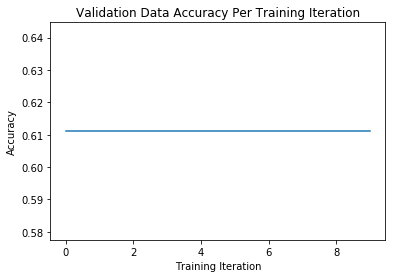

For dataset option=1-8, testing accuracy is 0.39622641509433965


In [1431]:


def Gate_Test(network,option):
    dt=1
    nbins=1000
    data=Data(dt,nbins)

    n_tests=100
    x,y,z=data.Generate_Gate_Data(option,n_tests)
    print("Dataset Spikes Established")
    
    network.Establish_Network(2)
    network.Add_New_Layer(1)
    
    network.Train([x,y],[z])
    print("Training Complete")

    (x_1_1,y_1_1),(x_1_0,y_1_0),(x_0_1,y_0_1),(x_0_0,y_0_0)=data.Generate_Gate_Test_Data()
    #x_1_1=[data.Encode(1),data.Encode(1)]
    #x_1_0=[data.Encode(1),data.Encode(0)]
    #x_0_1=[data.Encode(0),data.Encode(1)]
    #x_0_0=[data.Encode(0),data.Encode(0)]

    plotter=Spike_Plotter()
    
    z_1_1=network.Test([x_1_1,y_1_1])
    title = (str(option)+" Gate x=1,y=1")
    plotter.Raster_Plot(title,[x_1_1,y_1_1],z_1_1[0])

    z_1_0=network.Test([x_1_0,y_1_0])
    title = (str(option)+" Gate x=1,y=0")
    plotter.Raster_Plot(title,[x_1_0,y_1_0],z_1_0[0])
    
    
    z_0_1=network.Test([x_0_1,y_0_1])
    title = (str(option)+" Gate x=0,y=1")
    plotter.Raster_Plot(title,[x_0_1,y_0_1],z_0_1[0])
    
    z_0_0=network.Test([x_0_0,y_0_0])
    title = (str(option)+" Gate x=0,y=0")
    plotter.Raster_Plot(title,[x_0_0,y_0_0],z_0_0[0])

def Digit_Test(network, option):
    dt=1
    nbins = 1000
    digit_data = Digit_Data(dt,nbins)
    
    possible_outputs, (encoded_train_data,encoded_train_output),(encoded_test_data,test_values),(encoded_validation_data,validation_values) = digit_data.Parse_Digit_Dataset(option)
    print("Dataset Spikes Established")
    
    network.Establish_Network(64)
    network.Add_New_Layer(len(possible_outputs))
    
    
    number_of_training_iterations=10
    validation_spikes = network.Validation_Train(number_of_training_iterations,encoded_train_data,encoded_train_output,encoded_validation_data)
    print("Training and Validation Complete")
    
    test_spikes = []
    for i in range(len(encoded_test_data)):
        test_y = network.Test(encoded_test_data[i])
        test_spikes.append(test_y)
    print("Testing Complete")
    
    validation_accuracies = []
    for i in range(len(validation_spikes)):
        validation_predictions=digit_data.Decode_Digit_Results(validation_spikes[i],possible_outputs)
        validation_accuracies.append(digit_data.Determine_Accuracy(validation_values,validation_predictions))
    
    test_predictions=digit_data.Decode_Digit_Results(test_spikes,possible_outputs)
    test_accuracy=digit_data.Determine_Accuracy(test_values,test_predictions)
    
    plotter=Spike_Plotter()
    plotter.Validation_Plot(validation_accuracies)
    print("For dataset option="+str(option)+", testing accuracy is "+str(test_accuracy))
    
def Run_Testing(option):
    learning_rate=0.01
    minimum_potential=-0.3
    threshold_potential=1
    resting_potential=0
    delay=0.01
    A_minus=0.3
    A_plus=.8
    tau_minus=5
    tau_plus=8
    w_max=1
    w_min=-1

    network=Spiking_Neural_Network_Manager()
    network.Establish_Parameters(learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min)
    if option=='AND' or option=='OR' or option=='XOR':
        Gate_Test(network,option)
    elif option=='ALL' or option=='1-3' or option=='1-8':
        Digit_Test(network,option)

#Uncomment as needed for different tests
#Run_Testing('AND')    
#Run_Testing('OR')
Run_Testing("1-8")
#Run_Testing("3-8")
#Run_Testing("ALL")